In [1]:
# Make sure you're running Python 3.11.5, then install the pinned versions:
%pip install \
  python-louvain==0.16 \
  fastnode2vec==0.0.7 \
  networkx==3.4.1 \
  matplotlib==3.7.2 \
  numpy==1.25.2 \
  pandas==2.2.3 \
  scikit-learn==1.6.1 \
  scipy==1.13.1 \
  python-igraph==0.11.8 \
  leidenalg==0.10.2 \
  ipycytoscape==1.3.3

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ------ --------------------------------- 2.6/15.5 MB 30.2 MB/s eta 0:00:01
   ------ --------------------------------- 2.6/15.5 MB 30.2 MB/s eta 0:00:01
   ------------ --------------------------- 5.0/15.5 MB 8.2 MB/s eta 0:00:02
   ------------ --------------------------- 5.0/15.5 MB 8.2 MB/s eta 0:00:02
   ------------ --------------------------- 5.0/15.5 MB 8.2 MB/s eta 0:00:02
   ------------ --------------------------- 5.0/15.5 MB 8.2 MB/s eta 0:00:02
   ------------------ --------------------- 7.1/15.5 MB 4.7 MB/s eta 0:00:02
   ------------------ --------------------- 7.3/15.5 MB 4.9 MB/s eta 0:00:02
   ------------------ --------------------- 7.3/15.5 MB 4.9 MB/s eta 0:00:02
   ------------------ --------------------- 7.3/15.5 MB 4.9 MB/s eta 0:00:02
   ------------------ --------------------- 7.3/15.5 MB 4.9 MB/s eta 0:00:02
   ------------------------ --------------- 9.7/15.5 MB 3.9 MB/s eta 0:00:02
   -

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.2 requires joblib<1.4,>=1.2.0, but you have joblib 1.4.2 which is incompatible.
pycaret 3.3.2 requires pandas<2.2.0, but you have pandas 2.2.3 which is incompatible.
pycaret 3.3.2 requires scipy<=1.11.4,>=1.6.1, but you have scipy 1.13.1 which is incompatible.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.


## Getting the Data

To use this Jupyter Notebook for community detection on Facebook and Twitter networks, you need to download the `.tar.gz` files from the **Stanford Large Network Dataset Collection** at the following links:

- [Facebook](https://snap.stanford.edu/data/ego-Facebook.html)
- [Twitter](https://snap.stanford.edu/data/ego-Twitter.html)

Once downloaded, do the following:

1. Locate the downloaded `.tar.gz` files (e.g., `facebook.tar.gz` and `twitter.tar.gz`).
2. Extract them to this root folder, ensuring that the network files (e.g., `edges` or similar format) are accessible.
3. Update any file paths in the notebook code to point to your extracted dataset files.

With the datasets in place, you can then run the notebook cells to explore and analyze these networks using the Louvain, Girvan–Newman, and Leiden algorithms for community detection.


In [2]:
import tarfile
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import igraph  # from python-igraph
import leidenalg  # The Leiden community detection library

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from networkx.algorithms import community, centrality, assortativity
from scipy.sparse.linalg import eigsh
from fastnode2vec import Graph, Node2Vec
from fastnode2vec import Node2Vec as FastNode2Vec
from collections import defaultdict, Counter

# For reproducibility (optional)
np.random.seed(42)


def load_graph(file_path="facebook.tar.gz"):
    G = nx.Graph()
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".edges"):
                f = tar.extractfile(member)
                for line in f:
                    node1, node2 = map(int, line.decode().strip().split())
                    G.add_edge(node1, node2)
    return G
G = load_graph()
print(G)

Graph with 3959 nodes and 84243 edges


In [3]:
def basic_visualization(G, title="Graph Visualization", seed=42):
    """
    Plots a basic spring-layout visualization of the given (small) graph.
    """
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=seed)
    nx.draw_networkx(G, pos=pos, node_size=500, font_size=8)
    plt.title(title)
    plt.show()

## Centrality Measures

Below is a high-level explanation of what the `compute_and_show_centralities(G)` function does, along with some mathematical and interpretive context.

---

### 1. Degree Centrality

**Definition**  
For an undirected graph $G=(V, E)$ with $|V|$ vertices, the degree of a node $v$ is the number of edges incident to $v$, denoted $d(v)$. The **degree centrality** $C_D(v)$ of $v$ is typically given by:

$$
C_D(v) = \frac{d(v)}{|V| - 1}.
$$

In NetworkX, `nx.degree_centrality(G)` computes this measure for every node.

**Interpretation**  
- A node with **high degree centrality** often acts as a **hub** because it is directly connected to many other nodes.  
- In smaller social networks like Zachary’s Karate Club, the top degree nodes might be the instructor or certain highly connected members.  
- Nodes with **low degree centrality** occupy more peripheral roles.

---

### 2. PageRank

**Definition**  
PageRank is an iterative centrality measure where a node's importance is determined by both the quantity and quality of incoming links. The PageRank score $PR(v)$ of node $v$ is defined recursively as:

$$
PR(v) = \alpha \sum_{u \in \text{In}(v)} \frac{PR(u)}{d(u)} + (1 - \alpha)\frac{1}{|V|},
$$

where:
- $\alpha$ is the damping factor (usually 0.85),
- $\text{In}(v)$ is the set of nodes linking to $v$,
- $d(u)$ is the out-degree of node $u$.

In NetworkX, `nx.pagerank(G)` computes this using the power iteration method.

**Interpretation**  
- Nodes with **high PageRank** are influential not just because they have many connections, but because they are connected to **other influential nodes**.  
- Unlike degree centrality, PageRank distinguishes between being connected to low-importance vs. high-importance nodes.

---

### 3. Approximate Betweenness Centrality

**Definition**  
Approximate betweenness centrality estimates how often a node lies on the shortest paths between other nodes, but it does so by **sampling** a subset $k$ of nodes instead of computing all pairs. This is much faster and scalable for large graphs.

$$
C_B^{(approx)}(v) \approx \sum_{s \in S, t \neq v} \frac{\sigma_{s,t}(v)}{\sigma_{s,t}},
$$

where $S$ is a sample of source nodes.

In NetworkX, `nx.betweenness_centrality(G, k=200)` performs this approximation.

**Interpretation**  
- Approximated scores still capture **brokerage roles**, but much faster.  
- It's especially useful for **large-scale networks** where exact betweenness is computationally expensive.

---

### 4. Histogram of Degree Centrality

After computing degree centrality for each node, the function plots a histogram of those values. This helps us see how degree centrality is distributed in the graph:

- A **few high-degree nodes** and many low-degree nodes implies a more **hub-and-spoke** structure.  
- A relatively **flat** or **even** distribution suggests a network without strongly dominant hubs.

---

### 5. Top PageRank and Betweenness Plots

Instead of visualizing all values (which can be overwhelming in large graphs), the function plots only the **top 20 nodes** by PageRank and approximate betweenness centrality.

These bar plots help to:
- Highlight the **most influential or broker-like** nodes at a glance.
- Understand how influence or control is distributed across the network’s top tier.

---

### Why Perform These Analyses?

1. **Identify Hubs**: Degree centrality spotlights heavily connected nodes.  
2. **Identify Influencers**: PageRank highlights nodes that matter in the broader connection web.  
3. **Identify Bridges**: Approximate betweenness centrality uncovers nodes that connect communities.  
4. **Prepare for Community Detection**: Centrality metrics often reveal which nodes hold power or vulnerability within communities.

---

### Function Summary

In short, `compute_and_show_centralities(G)`:  

1. Prints the **top 5** nodes by **degree**, **PageRank**, and **approximate betweenness centrality**.  
2. Plots:
   - A **histogram** of degree centrality distribution  
   - A **bar chart** of top PageRank scores  
   - A **bar chart** of top approximate betweenness scores  
3. Provides insight into **key players**, **influential connectors**, and the **structural dynamics** of the network.

In [4]:
def compute_and_show_centralities(G, k_center = 200):
    """
    Computes and prints top 5 Degree Centrality, PageRank, and Approximate Betweenness Centrality.
    Also plots the histogram of degree centrality and top values for PageRank and Approx Betweenness.
    """
    print("--- Centrality Measures ---")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    deg_sorted = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)
    print("Top 5 nodes by Degree Centrality:")
    for node, val in deg_sorted[:5]:
        print(f"  Node {node} => {val:.3f}")

    # PageRank
    pagerank = nx.pagerank(G)
    pagerank_sorted = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
    print("\nTop 5 nodes by PageRank:")
    for node, val in pagerank_sorted[:5]:
        print(f"  Node {node} => {val:.3f}")


    # Plot distribution of degree centralities
    plt.figure(figsize=(6, 4))
    plt.hist(list(deg_centrality.values()), bins=10, edgecolor='black')
    plt.title("Distribution of Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot top PageRank values (e.g. top 20)
    top_n = 20
    top_pagerank = pagerank_sorted[:top_n]
    nodes_p, values_p = zip(*top_pagerank)

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(nodes_p)), values_p, tick_label=[str(n) for n in nodes_p])
    plt.title(f"Top {top_n} Nodes by PageRank")
    plt.xlabel("Node")
    plt.ylabel("PageRank Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



## Community Detection: Louvain, Girvan–Newman & Leiden

This section demonstrates three approaches to **community detection**:

1. **Louvain** (which maximizes modularity),
2. **Girvan–Newman** (which incrementally removes high-betweenness edges),
3. **Leiden** (an improvement over Louvain, typically faster and producing better-connected communities).

---

### 1. Louvain Method

**Algorithm Overview**  
The **Louvain** algorithm is a **greedy optimization** method that seeks to maximize a quantity called **modularity**. It proceeds in two major phases, repeated iteratively:

1. **Local movement** of nodes between communities:  
   - Each node starts in its own community.  
   - A node is moved to the community of its neighbor if that move yields the greatest increase (or smallest decrease) in **modularity**.
2. **Community aggregation** into “super-nodes”:  
   - After no more improvements can be made locally, each community is contracted into a single node.  
   - Edges between these new super-nodes are weighted by the sum of the edges between the original communities.  
   - The process then repeats until no further modularity gain is possible.

**Modularity**  
Let:
- $G = (V, E)$ be an undirected graph with $|V|$ nodes and $|E|$ edges.
- $A$ be its adjacency matrix, where $A_{ij} = 1$ if $(i, j) \in E$ and $0$ otherwise (for unweighted graphs).
- $k_i$ be the degree of node $i$.
- $m = |E|$ be the total number of edges.

A popular definition of **modularity** $Q$ for a given partition of nodes into communities is:

$$
Q = \frac{1}{2m} \sum_{i,j} \Bigl(A_{ij} - \frac{k_i\,k_j}{2m}\Bigr)\,\delta(c_i, c_j),
$$

where $ \delta(c_i, c_j) = 1 $ if nodes $i$ and $j$ belong to the same community, and 0 otherwise. The term $ \frac{k_i\,k_j}{2m} $ represents the probability that nodes $i$ and $j$ would be connected in a **null model** (a random graph preserving the nodes’ degrees).

**What the Function Returns**  
- **`partition`**: A dictionary mapping each node to its community ID (an integer).  
- **`mod_val`**: The final modularity of that partition.  
- **`groups`**: A dictionary of community ID $\to$ list of nodes in that community (helpful for inspection).

**Interpretation**  
- **High Modularity** (close to 1) suggests the network is well-structured into communities with dense intra-group connections and sparser inter-group connections.  
- **Low Modularity** (near 0 or negative) indicates minimal community structure—links are nearly as frequent between groups as within them.

---

### 2. Girvan–Newman Method

**Algorithm Overview**  
The **Girvan–Newman** approach focuses on **edge betweenness** — the number of shortest paths that pass through an edge. The main idea is:

1. Compute the **betweenness** of all edges in the network.  
2. **Remove** the edge with the **highest** betweenness.  
3. Recalculate betweenness for the new network.  
4. Repeat until the graph splits into separate components (communities).

Effectively, **Girvan–Newman** progressively eliminates edges that serve as “bridges” between communities. In practice, after each removal, you can check how the graph’s partition changes and evaluate modularity or other community quality metrics. The first partition (which we return in this function) typically yields **two main communities**.

**What the Function Returns**  
- **`communities`**: A list of the communities (each is a list of node IDs) in the first split (i.e., after removing the highest-betweenness edges until you get 2 groups).  
- **`partition_dict`**: A dictionary mapping each node to its community index (0 or 1).  
- **`mod_gn`**: The modularity value of that two-community partition, reusing the same modularity definition used by Louvain.

**Interpretation**  
- The **first split** often highlights the major division in the network (e.g., in Zachary’s Karate Club, the “instructor” faction vs. the “administrator” faction).  
- You can continue removing high-betweenness edges to produce additional partitions (3 communities, 4, etc.) until all edges are removed.  
- **Girvan–Newman** is more computationally expensive for large graphs.

---

### 3. Leiden Method

**Algorithm Overview**  
The **Leiden** algorithm is an improved version of the Louvain method. It addresses the issue of poorly connected communities that can arise in Louvain. **Leiden** ensures each community is internally well-connected, often resulting in better partitions and higher modularity. It performs local node movements more effectively and refines communities in multiple stages, making it typically faster and more reliable than Louvain for large networks.

**What the Function Returns**  
- **`partition_leiden`**: A dictionary mapping each node to its Leiden community ID.  
- **`mod_leiden`**: The final modularity achieved by the Leiden partition.  
- **`communities_leiden`**: A dictionary of community ID $\to$ list of nodes (similar to Louvain’s output).

**Interpretation**  
- **Leiden** is usually **faster** and provides more **stable** solutions compared to Louvain, especially on large or complex networks.  
- Because it refines communities that are insufficiently connected, Leiden often yields better-defined community structures.

---

### Summary

- **Louvain** is **fast** and scales well, producing high-modularity partitions — often considered a go-to approach for **large networks**.
- **Girvan–Newman** provides a **hierarchical** view of communities by repeated edge removal, but it is **computationally expensive**.
- **Leiden** is an **improvement** over Louvain, offering faster convergence and higher-quality partitions; it is generally **preferable** for large-scale or complex networks.
- All methods aim to uncover the **block structure** of a network, providing insight into how the graph naturally divides into subgroups.

The returned **modularity** values and **community memberships** can be used to compare how each method partitions the graph, highlighting different facets of community structure.


In [5]:

def detect_communities_louvain(G):
    """
    Runs Louvain community detection and returns:
      - partition (dict of node->community_id)
      - modularity
      - groups (community_id -> list of nodes)
    """
    partition = community_louvain.best_partition(G)
    mod_val = community_louvain.modularity(partition, G)
    
    groups = defaultdict(list)
    for node, comm_id in partition.items():
        groups[comm_id].append(node)
    
    return partition, mod_val, groups


def detect_communities_girvan_newman(G):
    """
    Runs Girvan-Newman and returns:
      - The *first* split (2 communities)
      - A dictionary for node->community_id
      - Modularity of that 2-community split
    """
    gn_iter = nx.algorithms.community.girvan_newman(G)
    first_partition = next(gn_iter)
    communities = list(sorted(map(sorted, first_partition)))

    # Convert partition to dict for modularity
    partition_dict = {}
    for i, comm_nodes in enumerate(communities):
        for n in comm_nodes:
            partition_dict[n] = i

    # Reuse Louvain's modularity function for convenience
    mod_gn = community_louvain.modularity(partition_dict, G)

    return communities, partition_dict, mod_gn

# because those graph are so big we need to prune the community formation if not it will take to much time
def girvan_newman_stop_early(G, desired_communities=2):
    """
    Runs the Girvan–Newman algorithm but stops when 
    the graph has 'desired_communities' or more connected components.
    
    :param G: NetworkX graph
    :param desired_communities: integer, the target number of communities (connected components)
    :return: a tuple (communities, partition_dict) representing the partition found
             when the desired number of communities is reached.
    """
    # Girvan–Newman is an iterator of partitions
    gn_iter = nx.algorithms.community.girvan_newman(G)
    
    # Keep track of the latest partition
    for partition_level in gn_iter:
        # partition_level is a tuple of sets (communities)
        communities = list(partition_level)
        
        # If we've reached the desired number of communities
        if len(communities) >= desired_communities:
            # Convert the communities to a dict: node -> community_id
            partition_dict = {}
            for i, comm_nodes in enumerate(communities):
                for node in comm_nodes:
                    partition_dict[node] = i
            
            return communities, partition_dict
    mod_gn = community_louvain.modularity(partition_dict, G)
    return communities, partition_dict, mod_gn

def detect_communities_leiden(G):
    """
    Converts a NetworkX graph to igraph, runs the Leiden algorithm,
    and returns:
        - partition_dict (node -> community_id)
        - modularity_score (float or None)
    """
    ig = igraph.Graph()
    nodes = list(G.nodes())
    ig.add_vertices(len(nodes))
    node_index = {node: i for i, node in enumerate(nodes)}

    edges = [(node_index[u], node_index[v]) for u, v in G.edges()]
    ig.add_edges(edges)

    # Run the Leiden algorithm with ModularityVertexPartition
    partition = leidenalg.find_partition(
        ig,
        leidenalg.ModularityVertexPartition
    )

    # Convert membership to a dict
    partition_dict = {}
    for i, node in enumerate(nodes):
        partition_dict[node] = partition.membership[i]

    # Check how 'quality' is exposed
    mod_score = partition.quality
    if callable(mod_score):
        # If 'quality' is a method
        mod_score = mod_score()

    return partition_dict, mod_score


## Spectral Clustering

This function demonstrates a **spectral clustering** approach using the **normalized Laplacian** of the graph \(G\). The high-level steps are:

1. **Compute the Normalized Laplacian**  
   For an undirected graph $G = (V, E)$, let $\mathbf{A}$ be the adjacency matrix and $\mathbf{D}$ be the diagonal degree matrix. The **normalized Laplacian** $\mathbf{L}_{\text{sym}}$ is defined as:

   $$
   \mathbf{L}_{\text{sym}} = \mathbf{I} \;-\; \mathbf{D}^{-\tfrac{1}{2}}\, \mathbf{A}\, \mathbf{D}^{-\tfrac{1}{2}}.
   $$

   In NetworkX, `nx.normalized_laplacian_matrix(G)` produces a sparse representation of $\mathbf{L}_{\text{sym}}$.

2. **Eigen-Decomposition**  
   We solve the eigenvalue problem:

   $$
   \mathbf{L}_{\text{sym}} \,\mathbf{x}_i = \lambda_i \,\mathbf{x}_i,
   $$

   obtaining eigenvalues $\{\lambda_i\}$ and corresponding eigenvectors $\{\mathbf{x}_i\}$.  
   - We sort these eigenvalues from smallest to largest.  
   - **Spectral clustering** typically leverages the eigenvectors corresponding to the *smallest* $k$ eigenvalues (beyond the trivial $\lambda = 0$), forming an embedding of dimension $k$.

3. **K-Means Clustering on Eigenvectors**  
   After extracting the top $k$ eigenvectors (each node becomes a $k$-dimensional point), we apply **K-Means** to group nodes into $k$ clusters. Each node’s coordinates come from its row in that truncated eigenvector matrix.

4. **Silhouette Score**  
   We evaluate cluster **cohesion** vs. **separation** using the **silhouette score**. A higher silhouette (close to 1) indicates well-separated clusters; a lower score (near 0 or negative) indicates overlapping or poorly separated clusters.

---

### What the Function Returns

1. **`labels`**: The cluster IDs (from 0 to $k-1$) assigned by K-Means.  
2. **`sil_score`**: The silhouette score for the resulting $k$-clustering in the eigenvector space.  
3. **`df_spectral`**: A DataFrame listing each node alongside its assigned cluster.

---

### Why Spectral Clustering?

- **Graph Partitioning**: Spectral methods rely on properties of the **graph Laplacian** to locate dense substructures. By analyzing the **lower-dimensional eigenvector space**, we can capture meaningful structural relationships between nodes.  
- **Interpretation**: Nodes close together in the eigenvector space often share **similar connectivity patterns** in the original graph, naturally forming cohesive subgroups.

Hence, spectral clustering provides a straightforward, **linear-algebraic** approach to **community detection**, well-suited for **moderate-sized** networks where computing eigenvectors is feasible.


In [6]:

def spectral_clustering(G, k=3):
    """
    Performs spectral clustering on graph G using the k smallest
    eigenvectors of the normalized Laplacian, then applies K-Means
    to those eigenvectors. Returns:
      - cluster labels
      - silhouette score
      - a DataFrame of (Node, Cluster)
    """

    # 1) Build the normalized Laplacian (as a sparse matrix)
    L = nx.normalized_laplacian_matrix(G)   # This is already sparse

    # 2) Eigen-decomposition on the sparse matrix
    #    Use eigsh for the k smallest eigenvalues (which='SM')
    vals, vecs = eigsh(L, k=k, which='SM')  # This keeps it sparse internally

    # (Optionally: sort them, though eigsh often returns them in ascending order of eigenvalues)
    # idx_sorted = np.argsort(vals)
    # vals = vals[idx_sorted]
    # vecs = vecs[:, idx_sorted]

    # 3) KMeans on the first k eigenvectors
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(vecs)

    # 4) Compute silhouette score
    sil_score = silhouette_score(vecs, labels)

    # 5) Build a DataFrame for inspection
    df_spectral = pd.DataFrame({'Node': list(G.nodes()), 'Cluster': labels})

    return labels, sil_score, df_spectral

## Node2Vec Clustering

This function applies the **Node2Vec** algorithm to generate **node embeddings**, then uses **K-Means** to cluster those embeddings into $k$ groups. Finally, it computes the **silhouette score** to gauge how well-defined the resulting clusters are in the embedding space.

---

### 1. Node2Vec Embedding

**Random-Walk-Based Embeddings**  
Node2Vec performs **biased random walks** on the graph, somewhat analogous to generating “sentences” in a **Word2Vec**-style training process:

1. From each node, it launches multiple random walks of length `walk_length`.  
2. Each random walk visits neighbors with probabilities influenced by BFS-like or DFS-like bias parameters (by default, Node2Vec sets sensible defaults if you don’t specify them).  
3. The sequences of visited nodes feed into a skip-gram learning model (like Word2Vec), where each node is treated as a “word.”

**Learned Vectors**  
After training, each node $v$ is associated with an embedding vector $\mathbf{z}_v \in \mathbb{R}^{\text{dimensions}}$. These vectors capture **higher-order proximity**: nodes that frequently co-occur on these random walks learn similar embeddings.

---

### 2. K-Means Clustering

Once Node2Vec produces these vectors:
1. We stack them into a matrix of size $\lvert V\rvert \times \text{dimensions}$.  
2. We apply **K-Means** to partition the node embeddings into $k$ clusters.

Nodes with similar embeddings (those that appear in similar random-walk contexts) tend to end up in the same cluster.

---

### 3. Silhouette Score

To measure how distinct these $k$ clusters are, we compute the **silhouette** (ranging from -1 to 1):

$$
\text{Silhouette} = \frac{b - a}{\max(a, b)},
$$

where:
- $a$ is the average intra-cluster distance (how close each node is to others in its own cluster),  
- $b$ is the average distance to the **nearest** other cluster.

A silhouette near 1 indicates clear separation between clusters, while a value near 0 or negative implies overlapping or poorly separated clusters.

---

### What the Function Returns

1. **`labels_n2v`**: The K-Means cluster ID (0 to $k-1$) for each node.  
2. **`sil_n2v`**: The silhouette score of the resulting clustering.  
3. **`df_n2v`**: A DataFrame mapping each node to its cluster ID.

---

### Why Use Node2Vec?

- **Higher-Order Structure**: By exploring multiple random walks, Node2Vec embeds nodes according to both local and semi-global connectivity patterns.  
- **Flexibility**: Adjusting parameters like `walk_length`, BFS/DFS biases ($p$ and $q$), and embedding dimensions lets you tailor embeddings to different network types.  
- **Ease of Clustering**: Once node embeddings are available, any standard clustering or classification method (like K-Means) can be applied, and metrics like the silhouette score help you assess the quality of those clusters.


In [7]:
def node2vec_clustering(G, dimensions=8, walk_length=20, num_walks=50, k=3):
    """
    Runs Node2Vec to generate embeddings,
    then KMeans (k clusters),
    and returns cluster labels, silhouette, and a DataFrame of (Node, Cluster).
    """
    node2vec = Node2Vec(
        G,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=1
    )
    model_n2v = node2vec.fit(window=5, min_count=1, batch_words=4)

    # Build embedding matrix
    nodes_list = sorted(G.nodes())
    embeddings_n2v = []
    for n in nodes_list:
        vec = model_n2v.wv[str(n)]  # keys are strings in node2vec
        embeddings_n2v.append(vec)

    embeddings_n2v = np.array(embeddings_n2v)

    kmeans_n2v = KMeans(n_clusters=k, random_state=42)
    labels_n2v = kmeans_n2v.fit_predict(embeddings_n2v)

    sil_n2v = silhouette_score(embeddings_n2v, labels_n2v)
    df_n2v = pd.DataFrame({'Node': nodes_list, 'Cluster': labels_n2v})

    return labels_n2v, sil_n2v, df_n2v

In [8]:
def fastnode2vec_clustering(G, dimensions=8, walk_length=20, num_walks=50, k=3, directed=False):
    """
    Runs fastnode2vec to generate embeddings,
    then KMeans (with k clusters),
    and returns cluster labels, silhouette score, and a DataFrame of (Node, Cluster).
    """
    
    G = Graph(G.edges, directed=directed, weighted=False)

    fast_node2vec = FastNode2Vec(
        G,
        dim=dimensions,
        walk_length=walk_length,
        window=5,
        workers=1
    )
    
    fast_node2vec.train(epochs=100)

    nodes_list = sorted(G.node_names)
    embeddings = []
    for n in nodes_list:
        vec = fast_node2vec.wv[n]
        embeddings.append(vec)
    embeddings = np.array(embeddings)

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    sil_score = silhouette_score(embeddings, labels)

    df_clusters = pd.DataFrame({'Node': nodes_list, 'Cluster': labels})

    return labels, sil_score, df_clusters


In [9]:
def analyze_graph(G, graph_name="Graph", do_plot=True, directed=False, k = 3):
    """
    Runs the entire pipeline on a given graph:
      1. Basic Info & Visualization (if do_plot=True)
      2. Centralities
      3. Louvain & LEIDEN
      4. Spectral Clustering
      5. Node2Vec
      6. Prints out comparisons
      7. Returns a dictionary containing relevant results (partitions, metrics, etc.)
    """
    max_display_nodes = 50

    print(f"\n==== Analyzing {graph_name} ====")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # 1) Visualization
    if do_plot and G.number_of_nodes() <= 200:
        basic_visualization(G, title=f"{graph_name} Visualization")

    # 2) Centralities
    compute_and_show_centralities(G)

    # 3a) Louvain
    print("\n--- Louvain Community Detection ---")
    louvain_partition, mod_louvain, louvain_groups = detect_communities_louvain(G)
    print(f"Louvain found {len(louvain_groups)} communities; Modularity = {mod_louvain:.4f}")
    if len(G) <= max_display_nodes:
        for cid, members in louvain_groups.items():
            print(f"  Community {cid}: {members}")
    else:
        print("  Community Sizes (Louvain):")
        for cid, members in louvain_groups.items():
            print(f"    Community {cid}: {len(members)} nodes")

    # 3b) Leiden (replaces Girvan-Newman)
    print("\n--- Leiden Community Detection ---")
    leiden_partition_dict, mod_leiden = detect_communities_leiden(G)

    leiden_groups = defaultdict(list)
    for node, cid in leiden_partition_dict.items():
        leiden_groups[cid].append(node)

    print(f"Leiden found {len(leiden_groups)} communities; ", end='')
    if isinstance(mod_leiden, (float, int)):
        print(f"Modularity = {mod_leiden:.4f}")
    else:
        print(f"Modularity = {mod_leiden}")

    if len(G) <= max_display_nodes:
        for cid, members in leiden_groups.items():
            print(f"  Community {cid}: {members}")
    else:
        print("  Community Sizes (Leiden):")
        for cid, members in leiden_groups.items():
            print(f"    Community {cid}: {len(members)} nodes")

    # Optional plots for large graphs
    if do_plot and len(G) > max_display_nodes:
        # Plot Louvain community sizes
        plt.figure(figsize=(6, 3))
        plt.bar(louvain_groups.keys(), [len(v) for v in louvain_groups.values()])
        plt.title("Louvain Community Sizes")
        plt.xlabel("Community ID")
        plt.ylabel("Size")
        plt.tight_layout()
        plt.show()

        # Plot Leiden community sizes
        plt.figure(figsize=(6, 3))
        plt.bar(leiden_groups.keys(), [len(v) for v in leiden_groups.values()])
        plt.title("Leiden Community Sizes")
        plt.xlabel("Community ID")
        plt.ylabel("Size")
        plt.tight_layout()
        plt.show()

    # 4) Spectral Clustering
    print(f"\n--- Spectral Clustering (k={k}) ---")
    labels_spectral, sil_spectral, df_spectral = spectral_clustering(G, k=k)
    print(f"Spectral silhouette (k={k}) = {sil_spectral:.4f}")
    if len(G) <= max_display_nodes:
        print(df_spectral.groupby('Cluster')['Node'].apply(list))
    else:
        print("  Spectral Clustering - Cluster Sizes:")
        print(df_spectral['Cluster'].value_counts().sort_index())

    # 5) Node2Vec
    print(f"\n--- Node2Vec + KMeans (k={k}) ---")
    labels_n2v, sil_n2v, df_n2v = fastnode2vec_clustering(G, k=k, directed=directed)
    print(f"Node2Vec silhouette (k={k}) = {sil_n2v:.4f}")
    if len(G) <= max_display_nodes:
        print(df_n2v.groupby('Cluster')['Node'].apply(list))
    else:
        print("  Node2Vec Clustering - Cluster Sizes:")
        print(df_n2v['Cluster'].value_counts().sort_index())

    # 6) Compare & Observations
    print("\n--- Comparison & Observations ---")
    print(f" > Louvain Modularity: {mod_louvain:.4f}")
    print(f" > Leiden Modularity:  {mod_leiden:.4f}")
    print(f" > Spectral Silhouette: {sil_spectral:.4f} (k={k})")
    print(f" > Node2Vec Silhouette: {sil_n2v:.4f}  (k={k})")

    print(f"\nDone analyzing {graph_name}.\n")

    # 7) Return a dictionary of results so you can reuse them
    results = {
        'louvain_partition': louvain_partition,
        'louvain_modularity': mod_louvain,
        'louvain_groups': louvain_groups,

        'leiden_partition_dict': leiden_partition_dict,
        'leiden_groups': leiden_groups,
        'leiden_modularity': mod_leiden,

        'spectral_labels': labels_spectral,
        'spectral_silhouette': sil_spectral,
        'spectral_df': df_spectral,

        'node2vec_labels': labels_n2v,
        'node2vec_silhouette': sil_n2v,
        'node2vec_df': df_n2v
    }
    return results



==== Analyzing Zachary's Karate Club ====
Nodes: 34, Edges: 78


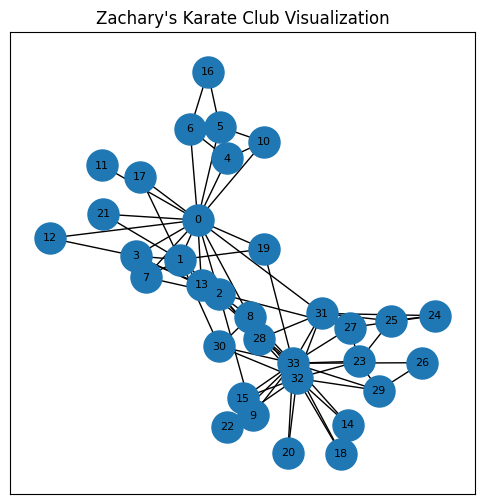

--- Centrality Measures ---
Top 5 nodes by Degree Centrality:
  Node 33 => 0.515
  Node 0 => 0.485
  Node 32 => 0.364
  Node 2 => 0.303
  Node 1 => 0.273

Top 5 nodes by PageRank:
  Node 33 => 0.097
  Node 0 => 0.089
  Node 32 => 0.076
  Node 2 => 0.063
  Node 1 => 0.057


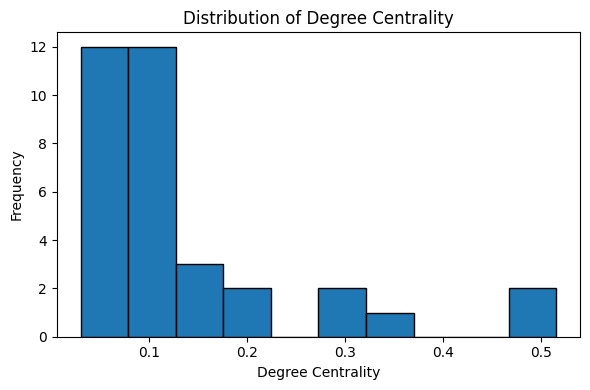

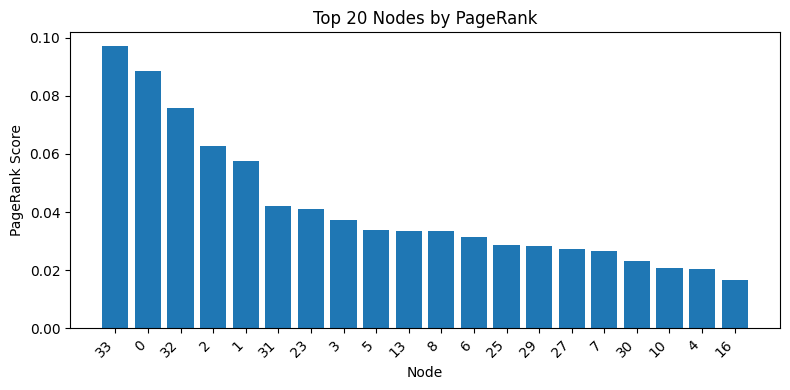


--- Louvain Community Detection ---
Louvain found 4 communities; Modularity = 0.4439
  Community 0: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  Community 1: [4, 5, 6, 10, 16]
  Community 3: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]
  Community 2: [24, 25, 28, 31]

--- Leiden Community Detection ---
Leiden found 4 communities; Modularity = 0.4198
  Community 1: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  Community 3: [4, 5, 6, 10, 16]
  Community 0: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
  Community 2: [23, 24, 25, 27, 28, 31]

--- Spectral Clustering (k=3) ---
Spectral silhouette (k=3) = 0.5682
Cluster
0              [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
1    [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27,...
2                                    [4, 5, 6, 10, 16]
Name: Node, dtype: object

--- Node2Vec + KMeans (k=3) ---


Reading graph:   0%|          | 0/78 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Node2Vec silhouette (k=3) = 0.5969
Cluster
0              [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
1    [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27,...
2                                    [4, 5, 6, 10, 16]
Name: Node, dtype: object

--- Comparison & Observations ---
 > Louvain Modularity: 0.4439
 > Leiden Modularity:  0.4198
 > Spectral Silhouette: 0.5682 (k=3)
 > Node2Vec Silhouette: 0.5969  (k=3)

Done analyzing Zachary's Karate Club.



In [10]:
G_karate = nx.karate_club_graph()
results_k = analyze_graph(G_karate, graph_name="Zachary's Karate Club", do_plot=True)


==== Analyzing Facebook connection ====
Nodes: 3959, Edges: 84243
--- Centrality Measures ---
Top 5 nodes by Degree Centrality:
  Node 2543 => 0.074
  Node 2347 => 0.073
  Node 1888 => 0.064
  Node 1800 => 0.062
  Node 1663 => 0.059

Top 5 nodes by PageRank:
  Node 483 => 0.001
  Node 3830 => 0.001
  Node 2313 => 0.001
  Node 376 => 0.001
  Node 2047 => 0.001


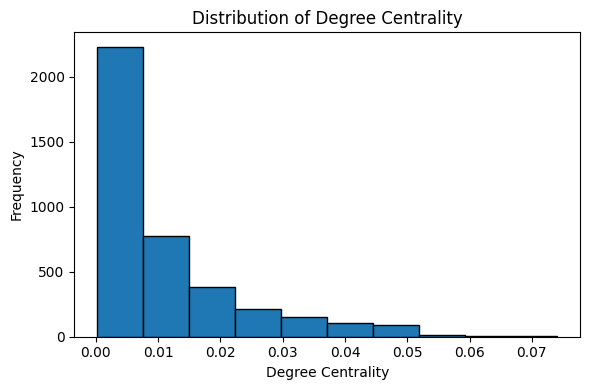

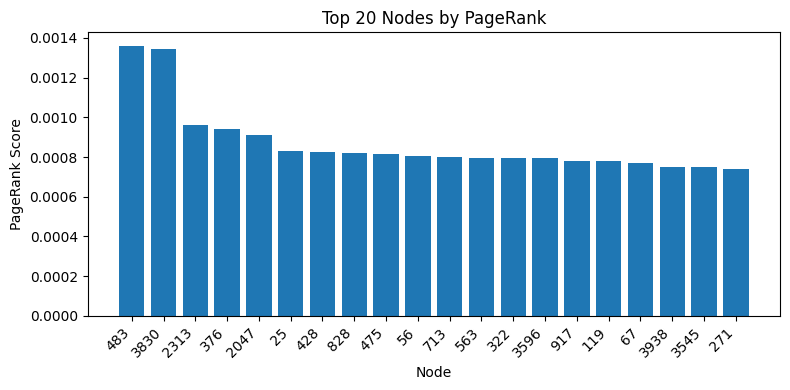


--- Louvain Community Detection ---
Louvain found 40 communities; Modularity = 0.8478
  Community Sizes (Louvain):
    Community 0: 229 nodes
    Community 1: 76 nodes
    Community 2: 10 nodes
    Community 4: 275 nodes
    Community 6: 112 nodes
    Community 7: 2 nodes
    Community 13: 364 nodes
    Community 9: 3 nodes
    Community 10: 2 nodes
    Community 11: 2 nodes
    Community 12: 10 nodes
    Community 23: 328 nodes
    Community 15: 25 nodes
    Community 16: 49 nodes
    Community 17: 45 nodes
    Community 18: 2 nodes
    Community 19: 8 nodes
    Community 20: 190 nodes
    Community 29: 220 nodes
    Community 22: 393 nodes
    Community 24: 500 nodes
    Community 25: 38 nodes
    Community 26: 6 nodes
    Community 27: 264 nodes
    Community 28: 48 nodes
    Community 31: 2 nodes
    Community 32: 2 nodes
    Community 33: 4 nodes
    Community 34: 2 nodes
    Community 35: 237 nodes
    Community 36: 73 nodes
    Community 37: 19 nodes
    Community 38: 137 nodes

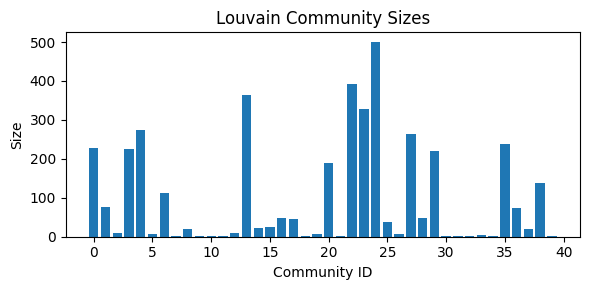

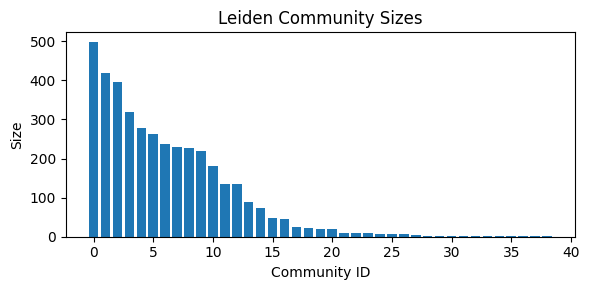


--- Spectral Clustering (k=10) ---
Spectral silhouette (k=10) = 0.5607
  Spectral Clustering - Cluster Sizes:
Cluster
0    1493
1       2
2       3
3     169
4     504
5    1061
6       4
7       6
8       4
9     713
Name: count, dtype: int64

--- Node2Vec + KMeans (k=10) ---


Reading graph:   0%|          | 0/84243 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
G_facebook = load_graph()
results_f = analyze_graph(G_facebook, graph_name="Facebook connection", do_plot=True, k = 10)


==== Analyzing Gplus connection ====
Nodes: 76245, Edges: 1242404
--- Centrality Measures ---
Top 5 nodes by Degree Centrality:
  Node 115485051 => 0.044
  Node 40981798 => 0.042
  Node 813286 => 0.039
  Node 43003845 => 0.036
  Node 22462180 => 0.033

Top 5 nodes by PageRank:
  Node 115485051 => 0.002
  Node 813286 => 0.002
  Node 40981798 => 0.001
  Node 7861312 => 0.001
  Node 3359851 => 0.001


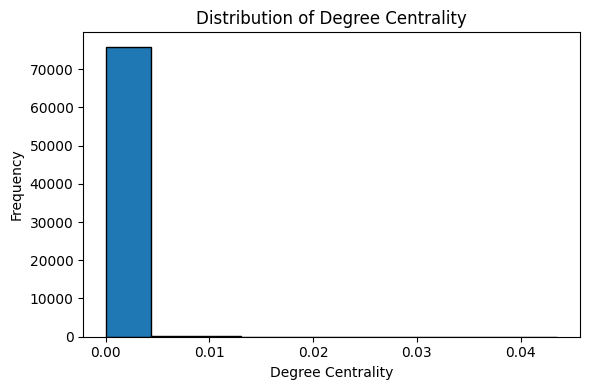

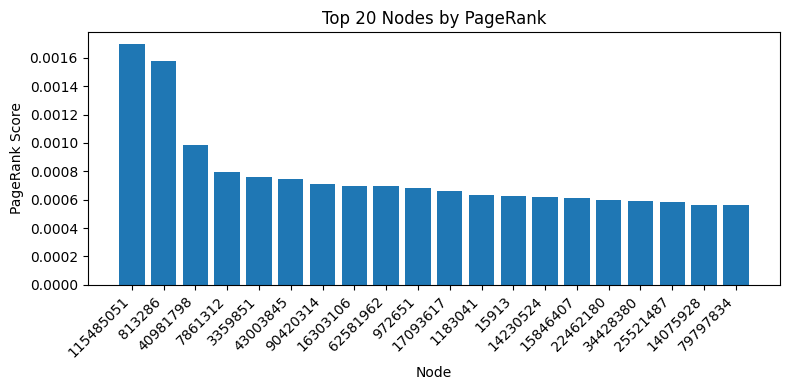


--- Louvain Community Detection ---
Louvain found 363 communities; Modularity = 0.8157
  Community Sizes (Louvain):
    Community 330: 8169 nodes
    Community 332: 5166 nodes
    Community 207: 2887 nodes
    Community 3: 2508 nodes
    Community 4: 9786 nodes
    Community 97: 2741 nodes
    Community 13: 1212 nodes
    Community 7: 140 nodes
    Community 8: 5925 nodes
    Community 157: 545 nodes
    Community 185: 706 nodes
    Community 244: 1340 nodes
    Community 14: 234 nodes
    Community 253: 380 nodes
    Community 128: 2815 nodes
    Community 71: 2284 nodes
    Community 18: 953 nodes
    Community 19: 3086 nodes
    Community 69: 439 nodes
    Community 21: 4319 nodes
    Community 22: 333 nodes
    Community 23: 573 nodes
    Community 26: 568 nodes
    Community 27: 1292 nodes
    Community 28: 350 nodes
    Community 29: 1053 nodes
    Community 30: 214 nodes
    Community 31: 2 nodes
    Community 33: 3 nodes
    Community 34: 3 nodes
    Community 35: 204 nodes
  

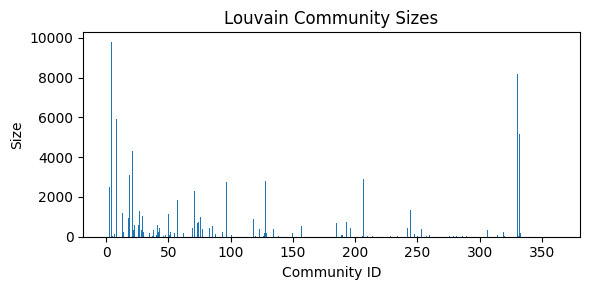

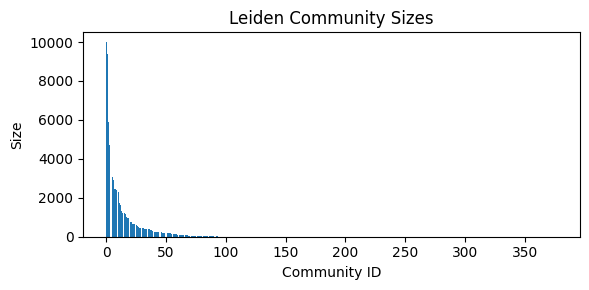


--- Spectral Clustering (k=3) ---
Spectral silhouette (k=3) = 0.9874
  Spectral Clustering - Cluster Sizes:
Cluster
0    76063
1      140
2       42
Name: count, dtype: int64

--- Node2Vec + KMeans (k=3) ---


Reading graph:   0%|          | 0/1242404 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Node2Vec silhouette (k=3) = 0.2065
  Node2Vec Clustering - Cluster Sizes:
Cluster
0    15131
1    41929
2    19185
Name: count, dtype: int64

--- Comparison & Observations ---
 > Louvain Modularity: 0.8157
 > Leiden Modularity:  0.8184
 > Spectral Silhouette: 0.9874 (k=3)
 > Node2Vec Silhouette: 0.2065  (k=3)

Done analyzing Gplus connection.



In [ ]:
G_twitter = load_graph(file_path="twitter.tar.gz")
results_t = analyze_graph(G_twitter, graph_name="Gplus connection", do_plot=True, directed=True, k = 3)

## Visualization Part

In [ ]:
import random

def sample_graph(G, max_nodes=500, seed=42):
    """
    Return a random induced subgraph of G with up to max_nodes nodes.
    """
    random.seed(seed)
    all_nodes = list(G.nodes())
    if len(all_nodes) <= max_nodes:
        return G.copy()
    sampled_nodes = random.sample(all_nodes, max_nodes)
    return G.subgraph(sampled_nodes).copy()

def visualize_communities(G, partition, title="Communities Visualization"):
    """
    Color-codes each node by its assigned community in 'partition'.
    
    :param G: NetworkX graph
    :param partition: dict { node : community_id }
    :param title: Plot title
    """
    # Layout for positioning the nodes
    pos = nx.spring_layout(G, seed=42)

    # Build a list of community IDs (colors) in the same order as G.nodes()
    communities = [partition[node] for node in G.nodes()]
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx(
        G, 
        pos=pos, 
        node_color=communities,  # node colors are based on community ID
        cmap=plt.cm.Set3,        # or any matplotlib colormap
        with_labels=False,
        node_size=50
    )
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_sampled_graph(G, partition, title="Communities Visualization"):
    # Sample G
    G_small = sample_graph(G, max_nodes=4000)
    # Re-run your original visualize_communities approach 
    # (or any approach) on G_small
    visualize_communities(G_small, 
                          {n: partition[n] for n in G_small.nodes()},
                          title=title)

def analyze_community_attributes(G, partition, attribute_name="location"):
    """
    For each community, gather the values of a given node attribute (e.g., 'location').
    Prints the top 3 most common values in that community.
    
    :param G: NetworkX graph with node attributes
    :param partition: dict { node : community_id }
    :param attribute_name: which node attribute to inspect (string)
    """
    # Step 1: Group nodes by community
    community_dict = defaultdict(list)
    for node, comm_id in partition.items():
        community_dict[comm_id].append(node)

    # Step 2: For each community, analyze the chosen attribute
    for comm_id, members in community_dict.items():
        # Gather attribute values
        attribute_values = []
        for m in members:
            # Access the node attribute (e.g., G.nodes[m]["location"])
            val = G.nodes[m].get(attribute_name, None)
            if val is not None:
                attribute_values.append(val)
        
        # Count frequencies
        freq = Counter(attribute_values)
        total = len(attribute_values)
        
        print(f"\nCommunity {comm_id} (size={len(members)}):")
        if total > 0:
            # Show top 3
            for attr_val, count in freq.most_common(3):
                pct = 100.0 * count / total
                print(f"  {attr_val}: {count} users ({pct:.1f}%)")
        else:
            print("  No attribute data available for this community.")

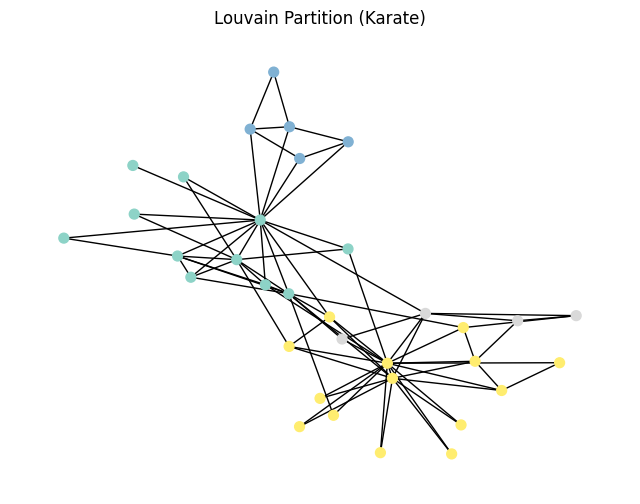

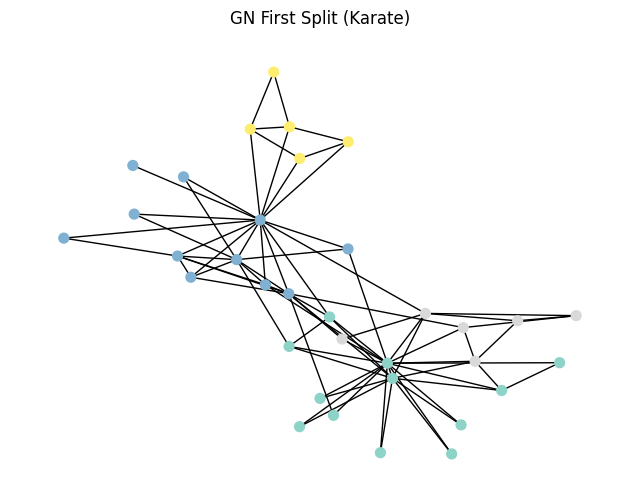

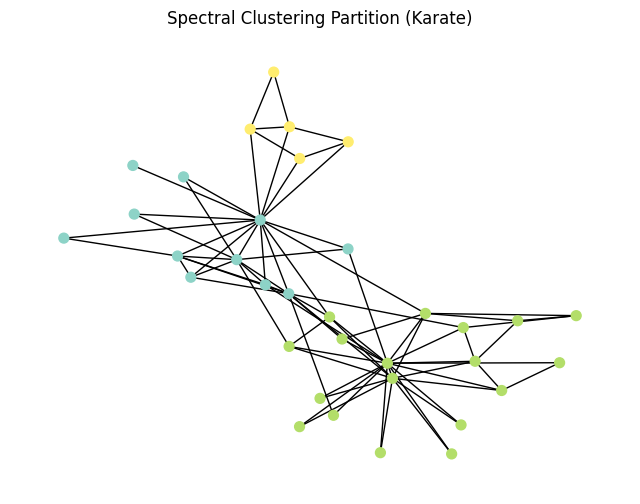

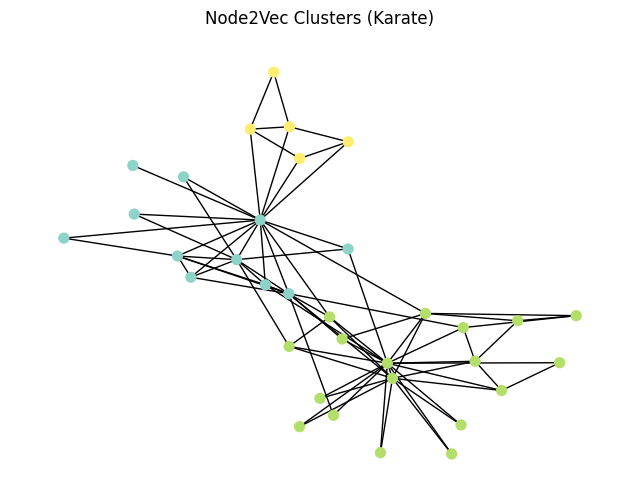

In [ ]:
# ====================
# KARATE
# ====================
visualize_communities(G_karate, results_k['louvain_partition'], title="Louvain Partition (Karate)")
#analyze_community_attributes(G_karate, results_k['louvain_partition'], attribute_name="location")

visualize_communities(G_karate, results_k['leiden_partition_dict'], title="GN First Split (Karate)")
#analyze_community_attributes(G_karate, results_k['leiden_partition_dict'], attribute_name="location")

# Build dict for Spectral approach
spectral_dict_k = dict(zip(
    results_k['spectral_df']['Node'],
    results_k['spectral_df']['Cluster']
))
visualize_communities(G_karate, spectral_dict_k, title="Spectral Clustering Partition (Karate)")
#analyze_community_attributes(G_karate, spectral_dict_k, attribute_name="location")

# Build dict for Node2Vec
node2vec_partition_k = dict(zip(
    results_k['node2vec_df']['Node'],
    results_k['node2vec_df']['Cluster']
))
visualize_communities(G_karate, node2vec_partition_k, title="Node2Vec Clusters (Karate)")
#analyze_community_attributes(G_karate, node2vec_partition_k, attribute_name="location")

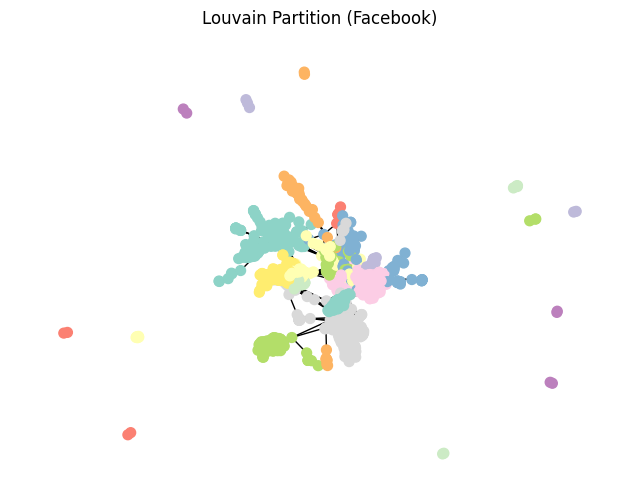

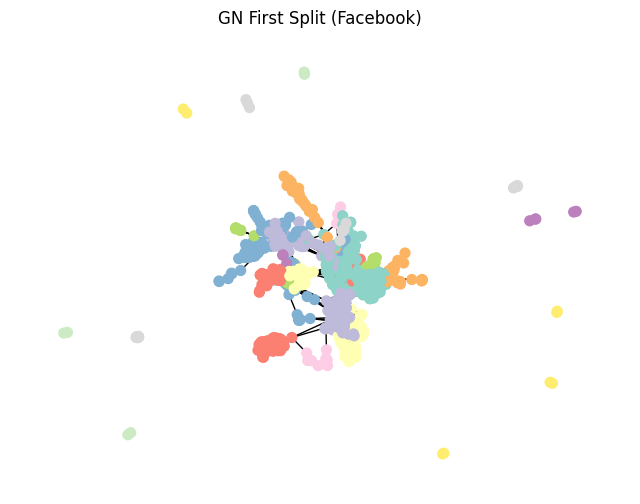

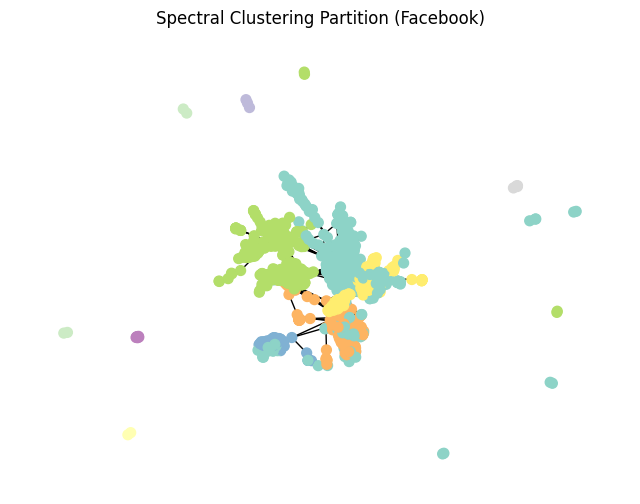

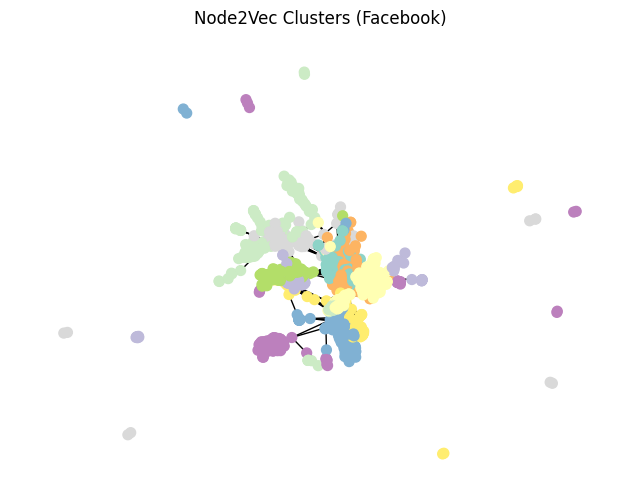

In [ ]:
# ====================
# FACEBOOK
# ====================
visualize_communities(G_facebook, results_f['louvain_partition'], title="Louvain Partition (Facebook)")
#analyze_community_attributes(G_facebook, results_f['louvain_partition'], attribute_name="location")

visualize_communities(G_facebook, results_f['leiden_partition_dict'], title="GN First Split (Facebook)")
#analyze_community_attributes(G_facebook, results_f['leiden_partition_dict'], attribute_name="location")

# Build dict for Spectral approach
spectral_dict_f = dict(zip(
    results_f['spectral_df']['Node'],
    results_f['spectral_df']['Cluster']
))
visualize_communities(G_facebook, spectral_dict_f, title="Spectral Clustering Partition (Facebook)")
#analyze_community_attributes(G_facebook, spectral_dict_f, attribute_name="location")

# Build dict for Node2Vec
node2vec_partition_f = dict(zip(
    results_f['node2vec_df']['Node'],
    results_f['node2vec_df']['Cluster']
))
visualize_communities(G_facebook, node2vec_partition_f, title="Node2Vec Clusters (Facebook)")
#analyze_community_attributes(G_facebook, node2vec_partition_f, attribute_name="location")

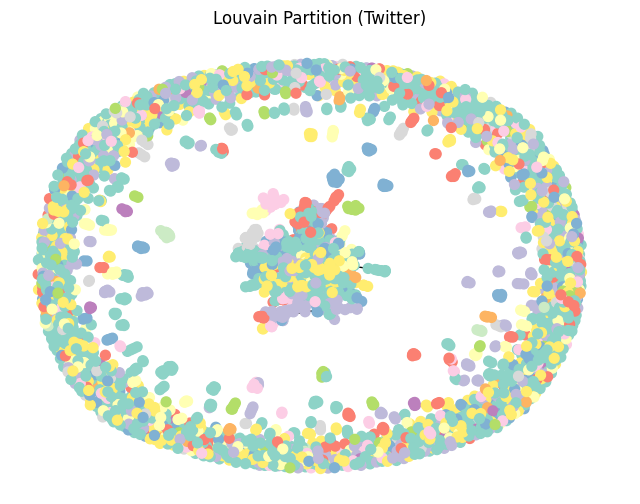

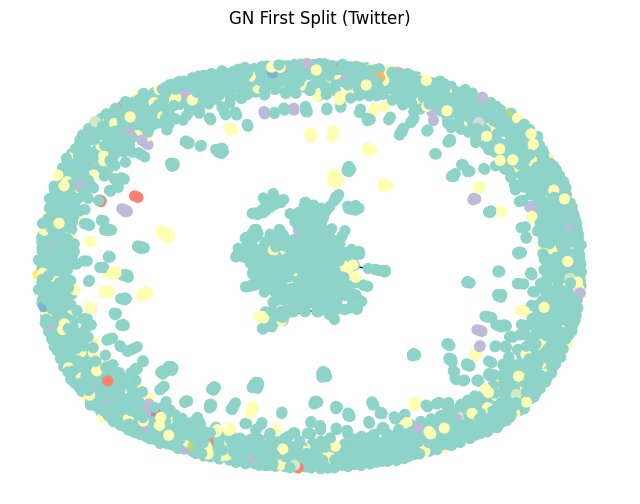

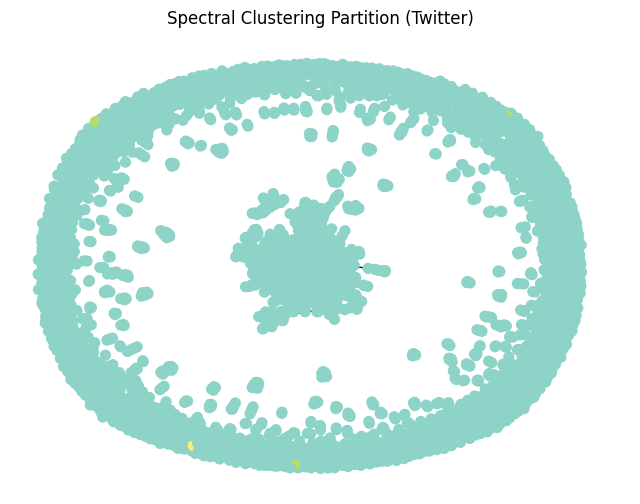

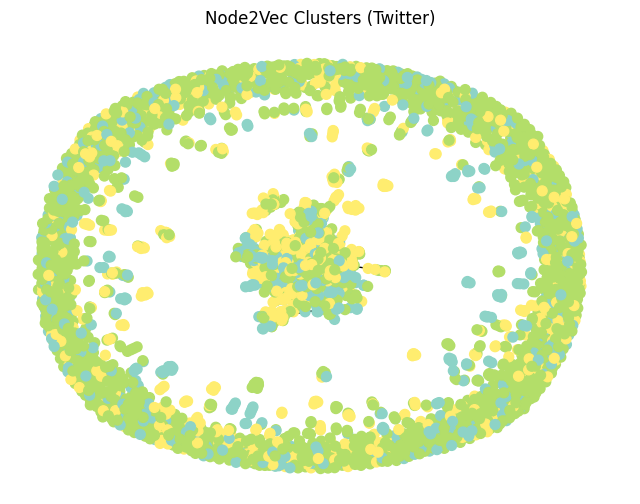

In [ ]:
# ====================
# TWITTER - he is to big to represented
# ====================
""" visualize_sampled_graph(G_twitter, results_t['louvain_partition'], title="Louvain Partition (Twitter)")

visualize_sampled_graph(G_twitter, results_t['leiden_partition_dict'], title="GN First Split (Twitter)")


# Build dict for Spectral approach
spectral_dict_t = dict(zip(
    results_t['spectral_df']['Node'],
    results_t['spectral_df']['Cluster']
))
visualize_sampled_graph(G_twitter, spectral_dict_t, title="Spectral Clustering Partition (Twitter)")

# Build dict for Node2Vec
node2vec_partition_t = dict(zip(
    results_t['node2vec_df']['Node'],
    results_t['node2vec_df']['Cluster']
))
visualize_sampled_graph(G_twitter, node2vec_partition_t, title="Node2Vec Clusters (Twitter)") """


# Theoretical Exercises 

## Exercise 1: Properties of the Normalised Laplacians

In spectral graph theory, in addition to the unnormalised Laplacian $L$, two commonly used normalised Laplacians are:

1. **Symmetric Normalised Laplacian**

   $$
   L_{\text{sym}} = D^{-\frac{1}{2}} L \, D^{-\frac{1}{2}} \;=\; I - D^{-\frac{1}{2}}\,A\,D^{-\frac{1}{2}}
   $$

2. **Random Walk Laplacian**

   $$
   L_{\text{rw}} = D^{-1} L \;=\; I - D^{-1} A
   $$

Below are the key properties of each.

---

### 1. Symmetric Normalised Laplacian

#### Symmetry

$$
L_{\text{sym}} = L_{\text{sym}}^T
$$

Hence, $L_{\text{sym}}$ is symmetric. As a result, all its eigenvalues are real, and its eigenvectors can be chosen to be orthonormal.


#### Positive Semi-Definiteness

For any vector $x$,

$$
x^T L_{\text{sym}} \, x \;\ge\; 0,
$$

which implies $L_{\text{sym}}$ is positive semi-definite. Consequently, all eigenvalues $\lambda$ satisfy

$$
\lambda \;\ge\; 0.
$$


#### Spectrum Bounds

All eigenvalues of $L_{\text{sym}}$ lie in the interval

$$
[\,0,\;2\,].
$$


#### Multiplicity of the Zero Eigenvalue

The number of connected components in the graph equals the multiplicity of the eigenvalue 0.

If a graph has $k$ disconnected components, then $0$ will be an eigenvalue of $L_{\text{sym}}$ with multiplicity $k$.


#### Usage in Spectral Clustering

The eigenvectors corresponding to the smallest eigenvalues (excluding the trivial zero eigenvalue if the graph is connected) are often used to embed the nodes into a lower-dimensional space for clustering.

---

### 2. Random Walk Laplacian

#### Non-Symmetry

In general,

$$
L_{\text{rw}} \;=\; D^{-1} L
$$

is not necessarily symmetric. However, \($L_{\text{rw}}$\) is similar to \($L_{\text{sym}}$\) via

$$
L_{\text{rw}}
\;=\;
D^{-\tfrac{1}{2}}\;L_{\text{sym}}\;D^{\tfrac{1}{2}},
$$

which ensures that $L_{\text{rw}}$ and $L_{\text{sym}}$ share the same eigenvalues.

#### Row-Stochastic Relationship

Observe that

$$
I \;-\; L_{\text{rw}}
\;=\;
D^{-1} A,
$$

which is a row-stochastic matrix (each row sums to 1). It represents the transition probabilities of a random walk on the graph.

#### Spectrum Bounds

Like \($L_{\text{sym}}$\), all eigenvalues of $L_{\text{rw}}$ lie within

$$
[\,0,\;2\,].
$$

Again, the eigenvalue $0$ appears with multiplicity equal to the number of connected components.

#### Interpretation of the Zero Eigenvalue

For $L_{\text{rw}}$, the eigenvector corresponding to the eigenvalue $0$ is (or is proportional to) the constant vector. In random-walk terms, it can be interpreted as a stationary distribution on a connected component.

#### Application in Random Walks and Diffusion

Since

$$
L_{\text{rw}} = I - D^{-1} A,
$$

it arises naturally in analyzing diffusion processes and random walks on graphs, emphasizing how probability transitions evolve between nodes.

---

### NB:

Both the symmetric normalised Laplacian and the random walk Laplacian offer advantages over the unnormalised Laplacian:

- **Degree Normalisation**:  
  They mitigate the influence of varying node degrees, making them particularly useful for graphs with heterogeneous connectivity.

- **Reflecting Graph Connectivity**:  
  The multiplicity of the zero eigenvalue indicates the number of disconnected components, a key feature in both spectral clustering and community detection.

- **Spectral Properties**:  
  Their eigenvalues lie in a known interval (typically \[0,2\] ), and the structure of the eigenvectors provides insights into the graph's community structure and the dynamics of random walks.

---

## Exercise 2: Compare the Different Clusterings Using Different Laplacian Eigenmaps

In the general spectral clustering approach, we choose an appropriate Laplacian (e.g., unnormalised $L$, symmetric normalised $L_{\text{sym}}$, or random walk $L_{\text{rw}}$) and then use the eigenvectors corresponding to the $k$ smallest eigenvalues (beyond the trivial zero eigenvalue if the graph is connected). By embedding the nodes in a $k$-dimensional space via these eigenvectors and then applying $k$-means, we obtain a partition of the graph into $k$ clusters.

When comparing different clusterings (for instance, using $L$ vs. $L_{\text{sym}}$ vs. $L_{\text{rw}}$), one can consider:

1. **Modularity**:  
   - Evaluate how well each clustering partitions the graph into densely connected communities. Higher modularity values indicate that there are more intra-cluster edges and fewer inter-cluster edges relative to a random baseline.

2. **Silhouette Score**:  
   - Compute the silhouette coefficient of the embedded points (rows of the eigenvector matrix $U$) after $k$-means. This measures how similar a node is to others within its cluster compared to nodes in other clusters. A higher silhouette (close to $1$) implies better separation.

3. **Visual Inspection**:  
   - For smaller graphs or 2D/3D embeddings (e.g., taking 2–3 eigenvectors), one can plot the node embeddings and color them by their assigned cluster to see how well-separated they appear.

4. **Community Sizes**:  
   - Check whether different Laplacians yield unbalanced clusters (one large cluster vs. many small ones) or more evenly distributed clusters.

---

## Exercise 3: Formalizing the Approximation of the **RatioCut** for Arbitrary $ k $

For an arbitrary number of clusters $ k $, the RatioCut minimization problem

$$
\min_{V_1, \dots, V_k}
\;\;
\text{RatioCut}(V_1, \dots, V_k)
\quad
\text{where}
\quad
\text{RatioCut}(V_1, \dots, V_k)
\;=\;
\frac{1}{2}
\sum_{i=1}^k
\frac{\left|\{(u,v)\in E : u\in V_i,\;v\in\overline{V_i}\}\right|}
{\lvert V_i\rvert},
$$

is **NP-hard** when the subsets $\{V_1,\dots,V_k\}$ must be discrete partitions of $V$. The standard **spectral relaxation** for approximating this problem is:

1. **Compute the $k$ Smallest Eigenvectors**  
   - Let $L$ be the (unnormalised) Laplacian of the graph.
   - Find the $k$ eigenvectors $ \mathbf{u}_1, \dots, \mathbf{u}_k $ corresponding to the $k$ smallest eigenvalues of $L$.  
     - If the graph is connected, the smallest eigenvalue is $0$, and its eigenvector is the all-ones vector (the trivial cluster). We typically use the next $k-1$ eigenvectors beyond this trivial one, so we end up with $k$ non-trivial eigenvectors in total.

2. **Build the Embedding Matrix**  
   - Form a matrix $U \;\in\; \mathbb{R}^{|V|\times k}$ whose $k$ columns are the eigenvectors from Step 1.  
   - Each row $U[v]$ is then the $k$-dimensional embedding of node $v$.

3. **Cluster the Embedded Points**  
   - Treat each node $v$ as a point in $\mathbb{R}^k$ given by $U[v]$.
   - Apply a standard clustering algorithm (e.g., $k$-means) on these row vectors to produce $k$ clusters.

4. **Obtain an Approximate RatioCut**  
   - The resulting partition of nodes from $k$-means corresponds to an approximate minimizer of the RatioCut objective.  
   - While this approach is only a relaxation of the original NP-hard problem, in practice it often yields high-quality partitions.

**Key Intuition**  
- By using the eigenvectors associated with the smallest eigenvalues of $L$, we find a subspace capturing “smooth” cuts in the graph.
- Embedding nodes into this low-dimensional space preserves structural information relevant to minimizing inter-cluster edges while avoiding excessively small clusters—i.e., approximating the RatioCut objective.

This general **$k$-way spectral clustering** procedure extends naturally from the simpler $k=2$ case (the Fiedler vector) to partitioning into multiple clusters.

---

## Exercise 4: Comparing node2vec Embeddings to Laplacian Eigenmaps

Both Laplacian eigenmaps and node2vec aim to learn low-dimensional representations for nodes in a graph, but they approach the task from very different angles.


### Objective and Formulation

- **Laplacian Eigenmaps:**  
  Laplacian eigenmaps are based on a spectral formulation. The method solves a relaxed optimization problem that minimizes
  $$
  \sum_{(u,v)\in E} \| \mathbf{z}_u - \mathbf{z}_v \|_2^2
  $$
  subject to constraints on the embeddings. This objective preserves local neighborhood relationships by ensuring that connected nodes have similar representations.

- **node2vec:**  
  In contrast, node2vec uses a biased random walk strategy to sample neighborhoods and then leverages the Skip-gram model to learn embeddings. Its objective is to maximize the likelihood of preserving network neighborhoods:
  $$
  \max_f \sum_{u \in V} \log \Pr(\mathcal{N}(u)|f(u))
  $$
  where $\mathcal{N}(u)$ is the set of nodes sampled from biased random walks starting at node $u$. This formulation is inspired by natural language processing techniques and is optimized via stochastic gradient descent.


### Computational Considerations

- **Laplacian Eigenmaps:**  
  Computing Laplacian eigenmaps requires the eigen-decomposition of the graph Laplacian, which becomes computationally expensive for large networks. The method is linear in nature and relies on standard linear algebra routines.

- **node2vec:**  
  node2vec, on the other hand, circumvents the need for eigen-decomposition by simulating biased random walks and using efficient optimization (e.g., negative sampling with SGD). This makes node2vec more scalable to large graphs.


### Flexibility and Expressiveness

- **Laplacian Eigenmaps:**  
  The approach inherently focuses on preserving local geometries in the graph. While this is effective for capturing nearby relationships (often useful in spectral clustering), it is relatively rigid and does not easily allow for tuning to capture more diverse notions of similarity.

- **node2vec:**  
  node2vec introduces flexibility through parameters (commonly denoted as $p$ and $q$) that control the bias of the random walks. These parameters allow the method to interpolate between:
  
  - **BFS-like behavior:** Favoring local exploration to capture structural equivalence.
  - **DFS-like behavior:** Encouraging longer-range walks that capture community (homophilic) structures.
  
  This flexibility lets node2vec capture a richer set of patterns in the graph beyond what is possible with a fixed spectral method.


### Quality and Interpretability of Embeddings

- **Laplacian Eigenmaps:**  
  The embeddings are directly tied to the eigenstructure of the Laplacian. For example, the Fiedler vector (the eigenvector corresponding to the second-smallest eigenvalue) is well known for providing a good bi-partition of the graph. However, the linear nature of this method may limit its ability to capture complex, non-linear relationships in the data.

- **node2vec:**  
  The embeddings learned by node2vec capture higher-order proximities by considering a broader, probabilistic view of node neighborhoods. This often results in representations that are more effective for downstream tasks such as node classification and link prediction, although they might be less directly interpretable in terms of classical spectral properties.


### Summary

- **Laplacian Eigenmaps** offer a mathematically elegant and interpretable solution grounded in spectral graph theory, best suited for preserving local geometric structure. Their reliance on eigen-decomposition can, however, limit scalability and flexibility.

- **node2vec** leverages random walks and a Skip-gram based objective to learn embeddings that are more flexible and scalable. Its parameterized random walk strategy allows one to tune the exploration to capture both local (structural equivalence) and global (community structure) relationships.

Ultimately, while Laplacian eigenmaps provide a strong baseline rooted in linear algebra, node2vec’s probabilistic and flexible framework often leads to superior performance in real-world tasks by capturing richer and more nuanced patterns in network data.
